In [97]:
import numpy as np 
import pandas as pd
import json
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [98]:
df = pd.read_csv('../raw_data/data.csv')
df.drop(['RowNumber','Surname'],axis=1,inplace=True)
df.head()

,CustomerId,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [99]:

df.NumOfProducts.value_counts()

NumOfProducts
1    5084
2    4590
3     266
4      60
Name: count, dtype: int64

## Data Preprocessing

### Outlier detection

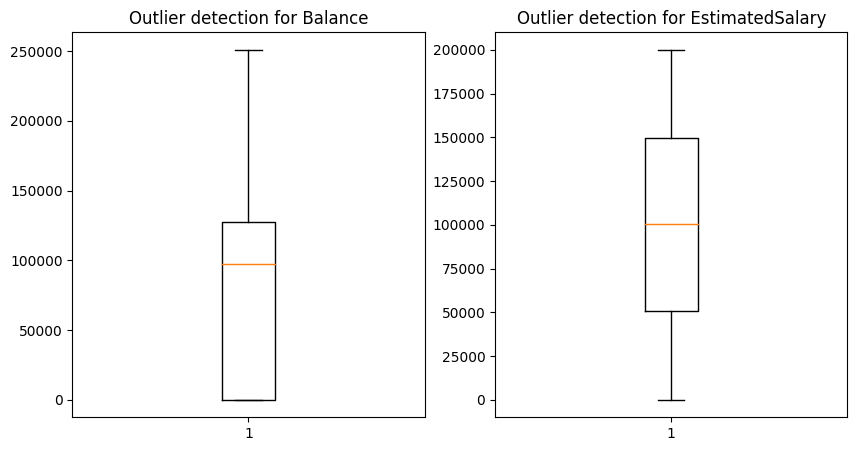

In [100]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].boxplot(df['Balance'])
ax[0].set_title("Outlier detection for Balance")

ax[1].boxplot(df['EstimatedSalary'])
ax[1].set_title('Outlier detection for EstimatedSalary')

plt.show();

- Its look like there is no outlier in numerical analysis but for a machine learning pipeline in productin we will define a functionality which is robut to outliers. To handle outlier case in the dataset we are using `RobustScaler`. It is robust to outliers and range betweeen 1st quantile and 3rd quantile.

### Class Imbalance
- In EDA part we've already seen how classes are imbalance but lets see here again

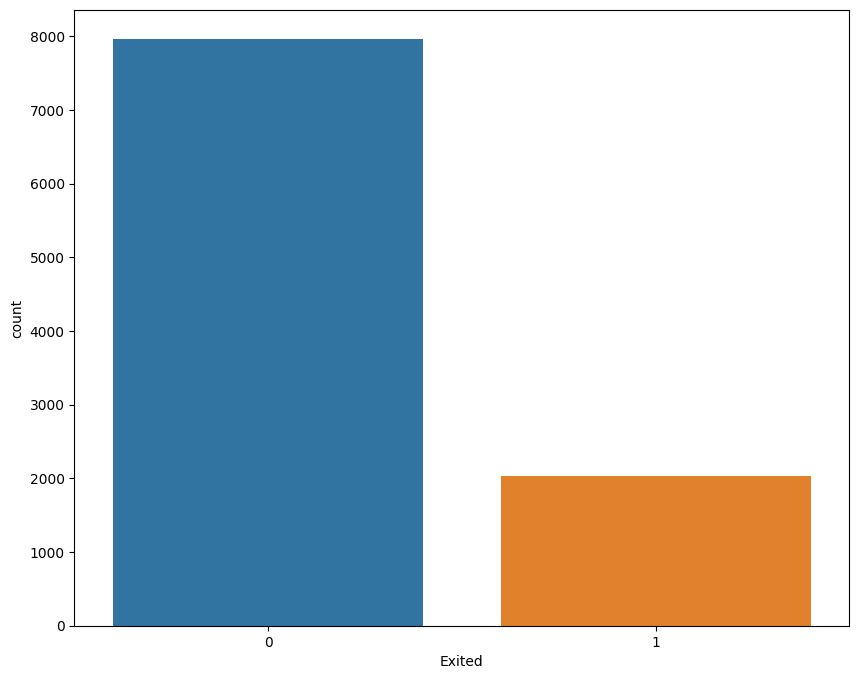

Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64

In [101]:
plt.figure(figsize=(10,8))
sns.countplot(x='Exited',data=df)
plt.show();

df['Exited'].value_counts(normalize=True)

In [102]:
## function to handle class imbalance
def fix_class_imbalance(X,y):
    print(f"Before sampling: {Counter(y)}")
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_resample(X,y)
    
    print(f"After sampling: {Counter(y_train_sm)}")
    return X_train_sm, y_train_sm

In [103]:
## splitting dataset into indepenedent and dependent variable
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

#### Create column transformer with 3 types of transformers

In [104]:
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

numeric_transformer = RobustScaler()
encoding_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder',encoding_transformer,cat_features),
        ('RobustScaler',numeric_transformer,num_features)
    ]
)

In [105]:
X = preprocessor.fit_transform(X)

In [106]:
# Seperated dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,y_train.shape

((8000, 14), (8000,))

In [107]:
X_train_sm, y_train_sm = fix_class_imbalance(X_train, y_train)

Before sampling: Counter({0: 6356, 1: 1644})
After sampling: Counter({0: 6356, 1: 6356})


In [108]:
X_train_sm.shape, y_train_sm.shape, X_test.shape, y_test.shape

((12712, 14), (12712,), (2000, 14), (2000,))

### Data Validation, Why we need?
The model is trained on the training set, and its performance is evaluated on the validation set. The hyperparameters are tuned to improve the model's performance on the validation set. Once the hyperparameters are selected, the model is retrained on the combined training and validation sets and evaluated on the test set to estimate its performance on new, unseen data.

Having a separate validation set helps ensure that the model generalizes well to new, unseen data and is not just memorizing the training set. This is important because the ultimate goal of a machine learning model is to make accurate predictions on new, unseen data.

In [109]:
X_train,X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

In [110]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (6400, 14)
y_train shape: (6400,)
X_valid shape: (1600, 14)
y_valid shape: (1600,)


## Model training and Evaluation

In [111]:
import sklearn.metrics as mt

class train_and_evaluate():
    def __init__(self,X_train,y_train,):
        self.X_train = X_train
        self.y_train = y_train

    def train(self,model):
        model.fit(self.X_train,self.y_train)
        self.y_pred = model.predict(self.X_train)
        return self.y_pred
    
    
    def evaluate(self,train=True):
        accuracy_score_ = mt.accuracy_score(self.y_train,self.y_pred)
        precision_score_ = mt.precision_score(self.y_train,self.y_pred)
        recall_score_ = mt.recall_score(self.y_train,self.y_pred)
        f1_score_ = mt.f1_score(self.y_train,self.y_pred)
        roc_auc_score_ = mt.roc_auc_score(self.y_train,self.y_pred)
        return accuracy_score_, precision_score_, recall_score_,f1_score_, roc_auc_score_
            
        
    def experiments(self,*args,**kwargs):
        model_list = [*args]
        model_names = list(map(lambda x: str(x).split('(')[0],model_list))
        accuracy_scores = []
        precision_scores = []
        recall_scores = []
        f1_scores = []
        roc_auc_scores = []
        for model in model_list:
            self.train(model)
            accuracy_score_, precision_score_, recall_score_,f1_score_, roc_auc_score_ = self.evaluate()
            accuracy_scores.append(accuracy_score_)
            precision_scores.append(precision_score_)
            recall_scores.append(recall_score_)
            f1_scores.append(f1_score_)
            roc_auc_scores.append(roc_auc_score_)
            results = pd.DataFrame(list(zip(model_names,accuracy_scores,precision_scores,recall_scores,f1_scores,roc_auc_scores)),
                                   columns=['Model_Name','Accuracy','Precision','Recall','F1','ROC_AUC']).sort_values(by=['F1'],ascending=False)
        return results

#### Experimenting on training set

In [112]:
model_exp_train = train_and_evaluate(X_train,y_train)
model_exp_train.experiments(XGBClassifier(),RandomForestClassifier(),LGBMClassifier(),SVC(),LogisticRegression(),KNeighborsClassifier(),BernoulliNB()) 

,Model_Name,Accuracy,Precision,Recall,F1,ROC_AUC
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
0,XGBClassifier,0.974531,0.991482,0.883827,0.934564,0.940930
2,LGBMClassifier,0.926094,0.941423,0.683371,0.791905,0.836177
5,KNeighborsClassifier,0.868125,0.797484,0.481397,0.600379,0.724861
3,SVC,0.864688,0.875208,0.399393,0.548488,0.692319
6,BernoulliNB,0.797188,0.512322,0.299924,0.378352,0.612976
4,LogisticRegression,0.811250,0.619256,0.214882,0.319053,0.590325


#### Experimenting on validation set 

In [113]:
model_exp = train_and_evaluate(X_valid,y_valid)
model_exp.experiments(XGBClassifier(),RandomForestClassifier(),LGBMClassifier(),SVC(),LogisticRegression(),KNeighborsClassifier(),BernoulliNB())

,Model_Name,Accuracy,Precision,Recall,F1,ROC_AUC
0,XGBClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
2,LGBMClassifier,1.000000,1.000000,1.000000,1.000000,1.000000
5,KNeighborsClassifier,0.866250,0.808743,0.452599,0.580392,0.712553
3,SVC,0.870000,0.878981,0.422018,0.570248,0.703546
6,BernoulliNB,0.789375,0.477064,0.318043,0.381651,0.614245
4,LogisticRegression,0.808125,0.581967,0.217125,0.316258,0.588531


#### Experimenting on unseen test data

In [114]:
model_exp = train_and_evaluate(X_test,y_test)
model_exp.experiments(XGBClassifier(),RandomForestClassifier(),LGBMClassifier(),SVC(),LogisticRegression(),KNeighborsClassifier(),BernoulliNB())

,Model_Name,Accuracy,Precision,Recall,F1,ROC_AUC
0,XGBClassifier,1.0000,1.000000,1.000000,1.000000,1.000000
1,RandomForestClassifier,1.0000,1.000000,1.000000,1.000000,1.000000
2,LGBMClassifier,0.9985,1.000000,0.992366,0.996169,0.996183
3,SVC,0.8740,0.898305,0.404580,0.557895,0.696690
5,KNeighborsClassifier,0.8555,0.768041,0.379135,0.507666,0.675566
6,BernoulliNB,0.8010,0.488479,0.269720,0.347541,0.600324
4,LogisticRegression,0.8120,0.562044,0.195929,0.290566,0.579296
